In [67]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 µs


In [68]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [69]:
def esn_chaos_prediction(X, N, iss, lr, ridge, seed, sr, seed_timesteps, nb_generations, train_len = 2000, forecast=1,):
    
    n, m = X.shape
    
    from reservoirpy.datasets import to_forecasting

    train_len = train_len

    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:train_len], y[:train_len]
    X_test, y_test = x[train_len:], y[train_len:]

    dataset = ((X_train, y_train), (X_test, y_test))
    
    # bestから取得したハイパーパラメータを設定
    N = N
    iss = iss
    lr = lr
    ridge = ridge
    seed = seed
    sr = sr

    # データセットからトレーニングとバリデーションデータを取得
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # モデルの構築
    reservoir = Reservoir(N, 
                        sr=sr, 
                        lr=lr, 
                        input_scaling=iss, 
                        seed=seed)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout

    # モデルの訓練と予測
    predictions = model.fit(X_train, y_train).run(X_val)
    
    seed_timesteps = seed_timesteps

    warming_inputs = X_test[:seed_timesteps]

    warming_out = model.run(warming_inputs, reset=True)  # warmup
    
    nb_generations = nb_generations

    X_gen = np.zeros((nb_generations, m))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = model(y)
        X_gen[t, :] = y
        
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]
    
    return X_gen, X_t, warming_out, warming_inputs

In [70]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

# レスラー方程式を解く関数
def rossler(t, state, a, b, c):
    x, y, z = state  
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# パラメータ
a = 0.2
b = 0.2
c = 5.7
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 2510)  # ここをあなたの指定に合わせました。

# ソルバー設定
t_eval = np.linspace(t_span[0], t_span[1], 25100)
sol = solve_ivp(rossler, t_span, initial_state, args=(a, b, c), t_eval=t_eval)

# 時間と状態変数をデータフレームに格納しCSVに保存
data = pd.DataFrame({
    'Time': sol.t,
    'X': sol.y[0],
    'Y': sol.y[1],
    'Z': sol.y[2]
})
data.to_csv('rossler_dataset.csv', index=False)

# CSVファイルから読み込む
data_loaded = pd.read_csv('rossler_dataset.csv')

# 時間を除いたデータのみの配列を取得
X = data_loaded[['X', 'Y']].values

# 配列の形状を表示（期待される出力は (25100, 3)）
print(X.shape)


(25100, 2)


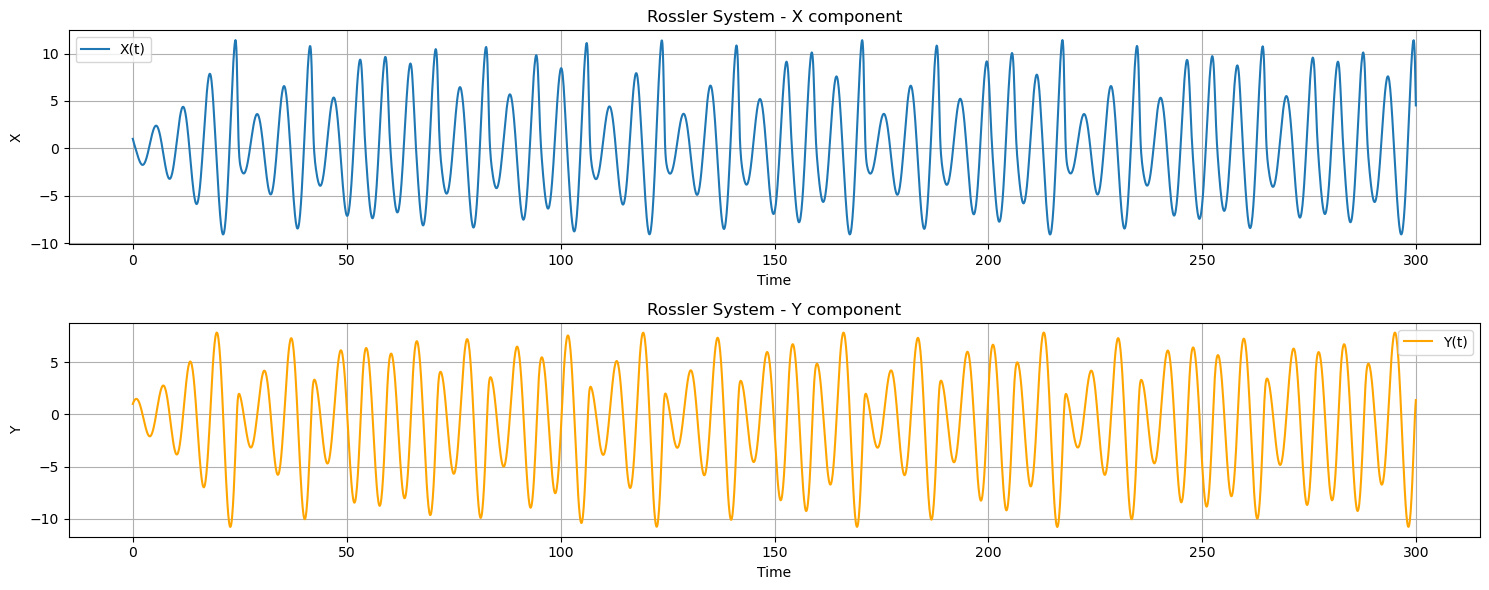

In [71]:
import matplotlib.pyplot as plt

sample = 3000

# サブプロットを作成して、x と y の時系列データを横に並べてプロット
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))  # 1行2列のサブプロット

# X(t)のデータを左側のサブプロットにプロット
axes[0].plot(sol.t[:sample], sol.y[0][:sample], label='X(t)')
axes[0].set_title('Rossler System - X component')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('X')
axes[0].legend()
axes[0].grid(True)

# Y(t)のデータを右側のサブプロットにプロット
axes[1].plot(sol.t[:sample], sol.y[1][:sample], label='Y(t)', color='orange')
axes[1].set_title('Rossler System - Y component')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Y')
axes[1].legend()
axes[1].grid(True)

# サブプロット間のスペースを調整
plt.tight_layout()

# グラフを表示
plt.show()


In [72]:
seed_timesteps = 100
nb_generations = 400

In [74]:
X_gen, X_t, warming_out, warming_inputs = esn_chaos_prediction(X, 500, 0.15716834911966804, 0.8156304946175557, 4.290374941230941e-08, 1234, 1.0385323042151453, seed_timesteps, nb_generations)

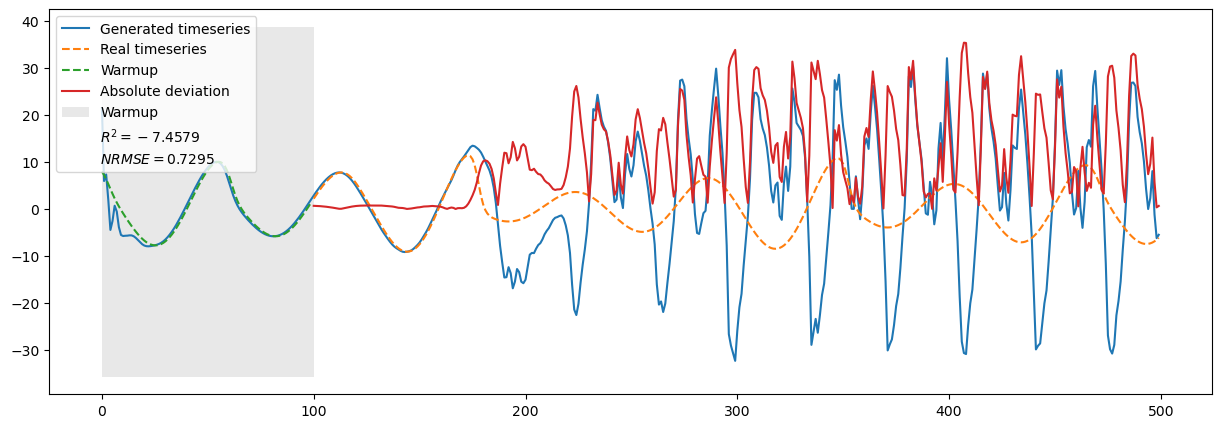

In [75]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

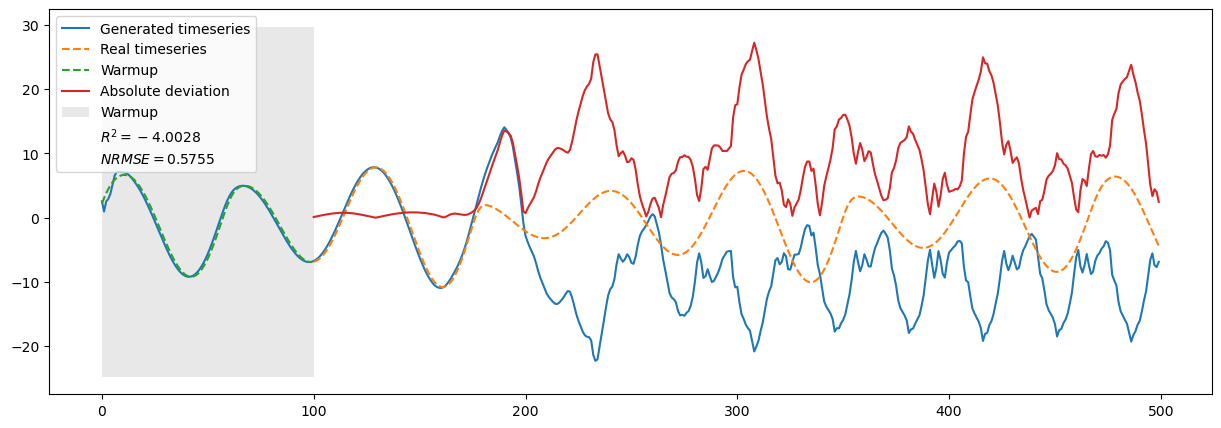

In [76]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

In [77]:
X

array([[ 1.        ,  1.        ],
       [ 0.81381597,  1.11163809],
       [ 0.64677307,  1.20777732],
       ...,
       [-5.77102208, -7.36999255],
       [-5.00049535, -8.06361248],
       [-4.1640113 , -8.69003864]])